In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

# 디바이스 설정 (GPU 사용 가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_data(train_transforms=None, test_transforms=None):
    if train_transforms is None:
        train_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    if test_transforms is None:
        test_transforms = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    train_dataset = CIFAR10(root='./data', train=True, download=False, transform=train_transforms)
    test_dataset = CIFAR10(root='./data', train=False, download=False, transform=test_transforms)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
    return train_loader, test_loader

def setup_model():
    model = resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    return model.to(device)

def train_model(model, train_loader, criterion, optimizer, num_epochs=60):
    model.train()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            if batch_idx % 100 == 99:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {running_loss / 100:.4f}, Accuracy: {100 * correct / total:.2f}%")
                running_loss = 0.0
    
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            c = (predicted == targets).squeeze()
            for i in range(len(targets)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    overall_accuracy = 100 * correct / total
    class_accuracy = [100 * class_correct[i] / class_total[i] for i in range(10)]
    return overall_accuracy, class_accuracy
    # classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # plt.figure(figsize=(10, 5))
    # plt.bar(np.arange(10), class_accuracy, tick_label=classes)
    # plt.xlabel('Class')
    # plt.ylabel('Accuracy (%)')
    # plt.title('Accuracy per Class')
    # plt.show()
    # for i, acc in enumerate(class_accuracy):
    #     print(f"{classes[i]}: {acc:.2f}%")

def main(train_transforms=None, test_transforms=None):
    train_loader, test_loader = load_data(train_transforms, test_transforms)
    model = setup_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1.0e-6)
    train_model(model, train_loader, criterion, optimizer)
    torch.save(model.state_dict(), './model/cifar10_model.pth')  # 모델 저장

def load_model(filepath):
    model = setup_model()
    model.load_state_dict(torch.load(filepath))
    model.eval()  # 평가 모드로 전환
    return model

In [81]:
# Transformations to test
transformations = {
    "original": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "crop": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "flip": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "color_jitter": transforms.Compose([
        transforms.Resize(224),
        transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "grayscale": transforms.Compose([
        transforms.Resize(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "translation": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "shearing": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomAffine(degrees=0, shear=10),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "rotation": transforms.Compose([
        transforms.Resize(224),
        transforms.RandomRotation(degrees=180),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "cutout": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    ]),
    "noise_injection": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Lambda(lambda img: img + 0.1 * torch.randn_like(img)),
    ]),
    "kernel_filtering": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(9, 11)),
    ]),
    "random_erasing": transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
    ]),
}

In [ ]:
main()

In [83]:
import json

# 결과를 저장할 딕셔너리
results = {}

# 모델 로드
loaded_model = load_model('./model/cifar10_model.pth')

# 각 transform에 대해 평가 수행
for name, transform in transformations.items():
    _, test_loader = load_data(None, transform)
    overall_accuracy, class_accuracy = evaluate_model(loaded_model, test_loader)
    results[name] = {
        "overall_accuracy": overall_accuracy,
        "class_accuracy": class_accuracy
    }

# 결과를 저장할 파일 경로
results_filepath = './results/cifar10_results.json'

# results 딕셔너리를 JSON 파일로 저장
with open(results_filepath, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {results_filepath}")

# 결과 출력
for name, result in results.items():
    print(f"Transform: {name}")
    print(f"Overall Accuracy: {result['overall_accuracy']:.2f}%")
    print(f"Class Accuracy: {result['class_accuracy']}\n")

/tmp/ipykernel_492426/2338287729.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Results saved to ./results/cifar10_results.json
Transform: original
Overall Accuracy: 82.90%
Class Accuracy: [85.7, 87.6, 73.7, 64.4, 83.4, 73.1, 85.7, 92.1, 93.3, 90.0]

Transform: crop
Overall Accuracy: 50.03%
Class Accuracy: [41.1, 32.7, 47.7, 54.1, 61.5, 38.3, 31.8, 55.8, 82.8, 54.5]

Transform: flip
Overall Accuracy: 57.34%
Class Accuracy: [72.9, 49.2, 50.0, 48.2, 63.0, 59.1, 68.5, 50.2, 55.0, 57.3]

Transform: color_jitter
Overall Accuracy: 66.63%
Class Accuracy: [73.1, 64.5, 59.7, 53.6, 71.1, 49.0, 66.4, 78.7, 81.7, 68.5]

Transform: grayscale
Overall Accuracy: 79.11%
Class Accuracy: [83.3, 82.7, 68.0, 62.0, 74.8, 73.2, 77.9, 89.6, 92.7, 86.9]

Transform: translation
Overall Accuracy: 76.58%
Class Accuracy: [71.6, 85.8, 72.0, 66.4, 79.7, 66.4, 72.3, 89.4, 85.3, 76.9]

Transform: shearing
Overall Accuracy: 80.06%
Class Accuracy: [80.3, 86.8, 72.2, 62.7, 78.7, 68.3, 83.7, 91.5, 92.4, 84.0]

Transform: rotation
Overall Accuracy: 31.63%
Class Accuracy: [32.3, 22.1, 37.3, 47.1, 18.8,

/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 82.90%


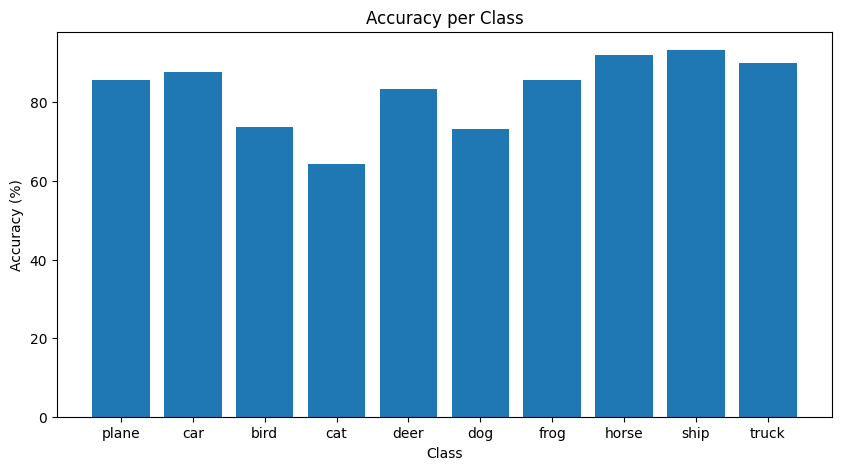

plane: 85.70%
car: 87.60%
bird: 73.70%
cat: 64.40%
deer: 83.40%
dog: 73.10%
frog: 85.70%
horse: 92.10%
ship: 93.30%
truck: 90.00%


In [45]:
# 모델 불러오기
loaded_model = load_model('./model/cifar10_model.pth')

# 평가
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 49.41%


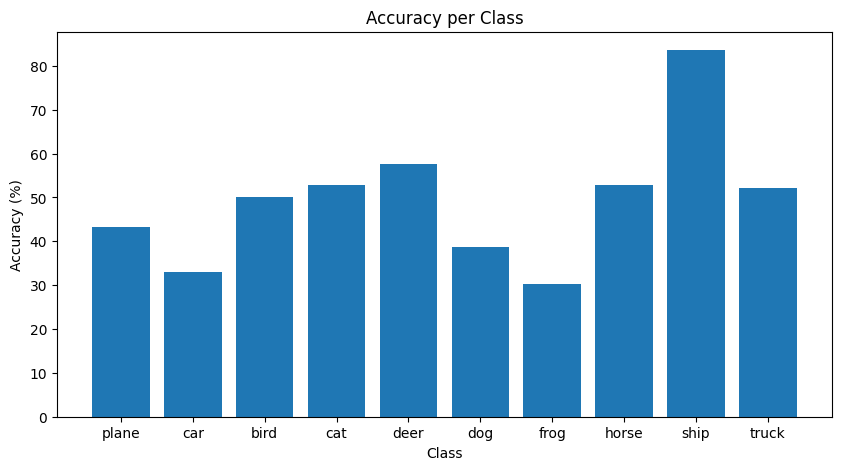

plane: 43.30%
car: 32.90%
bird: 50.00%
cat: 52.80%
deer: 57.60%
dog: 38.70%
frog: 30.20%
horse: 52.80%
ship: 83.60%
truck: 52.20%


In [51]:
loaded_model = load_model('./model/cifar10_model.pth')

# Crop
test_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 57.77%


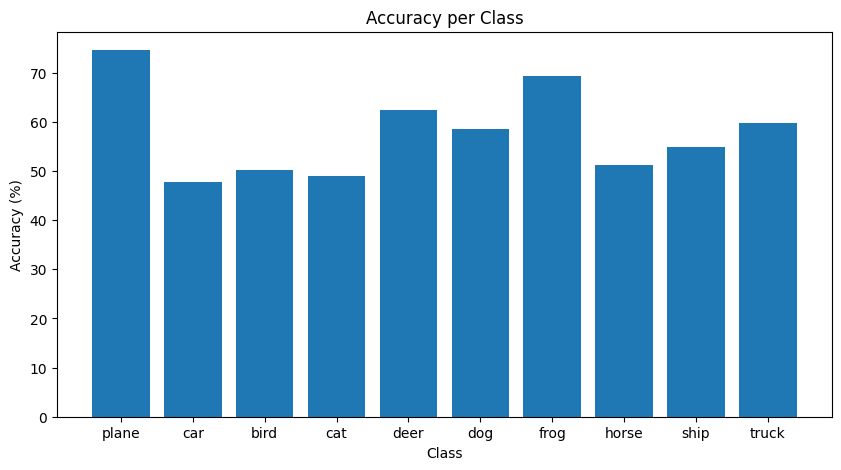

plane: 74.60%
car: 47.70%
bird: 50.10%
cat: 48.90%
deer: 62.50%
dog: 58.60%
frog: 69.30%
horse: 51.30%
ship: 54.90%
truck: 59.80%


In [52]:
loaded_model = load_model('./model/cifar10_model.pth')

# Flip
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 66.73%


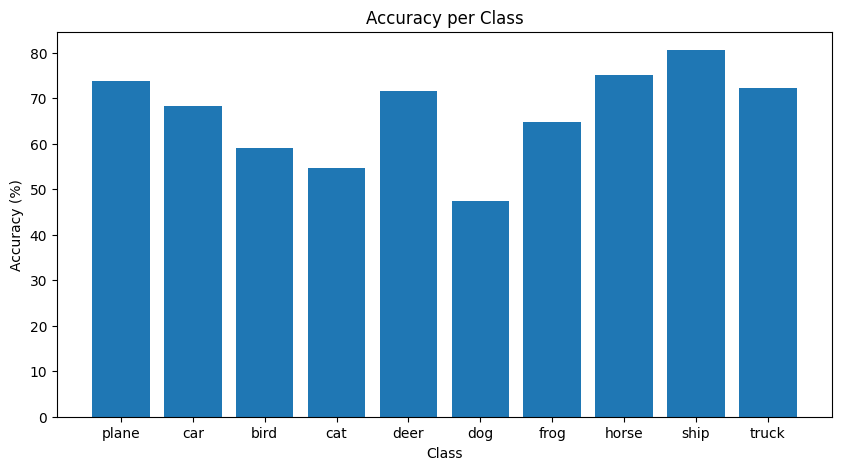

plane: 73.90%
car: 68.20%
bird: 59.00%
cat: 54.60%
deer: 71.50%
dog: 47.50%
frog: 64.70%
horse: 75.10%
ship: 80.60%
truck: 72.20%


In [53]:
loaded_model = load_model('./model/cifar10_model.pth')

# Color_jitter
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 79.11%


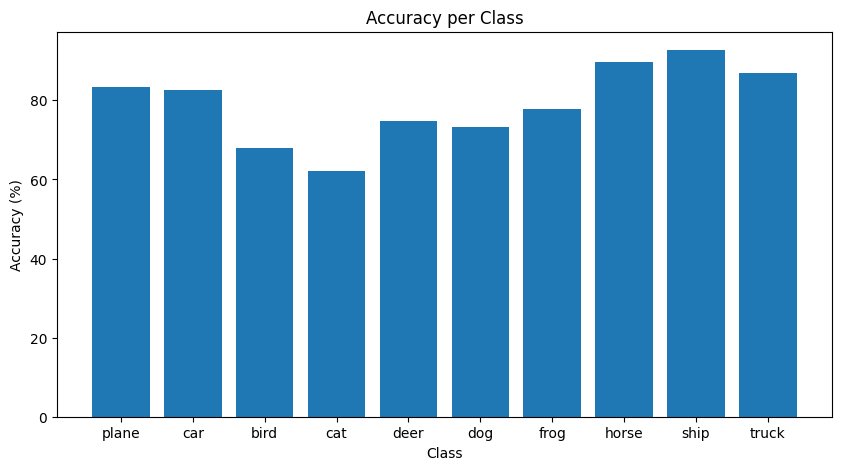

plane: 83.30%
car: 82.70%
bird: 68.00%
cat: 62.00%
deer: 74.80%
dog: 73.20%
frog: 77.90%
horse: 89.60%
ship: 92.70%
truck: 86.90%


In [54]:
loaded_model = load_model('./model/cifar10_model.pth')

# Grayscale
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 76.14%


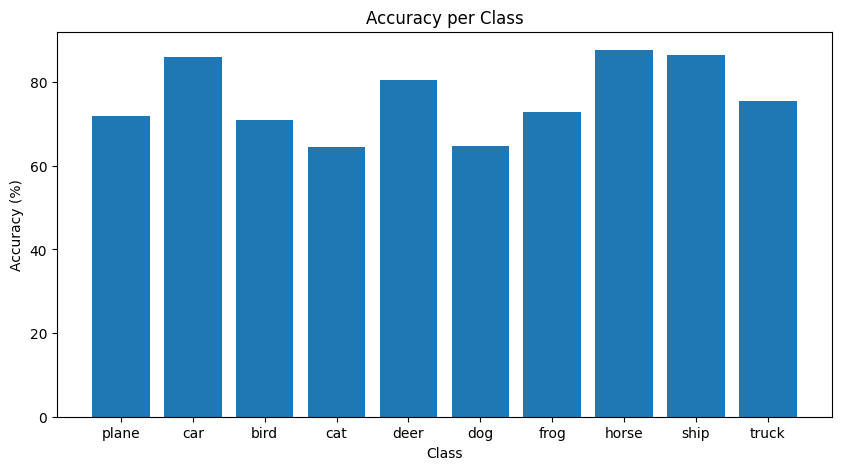

plane: 71.90%
car: 86.00%
bird: 71.00%
cat: 64.60%
deer: 80.50%
dog: 64.70%
frog: 72.90%
horse: 87.70%
ship: 86.50%
truck: 75.60%


In [55]:
loaded_model = load_model('./model/cifar10_model.pth')

# Translation
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 80.20%


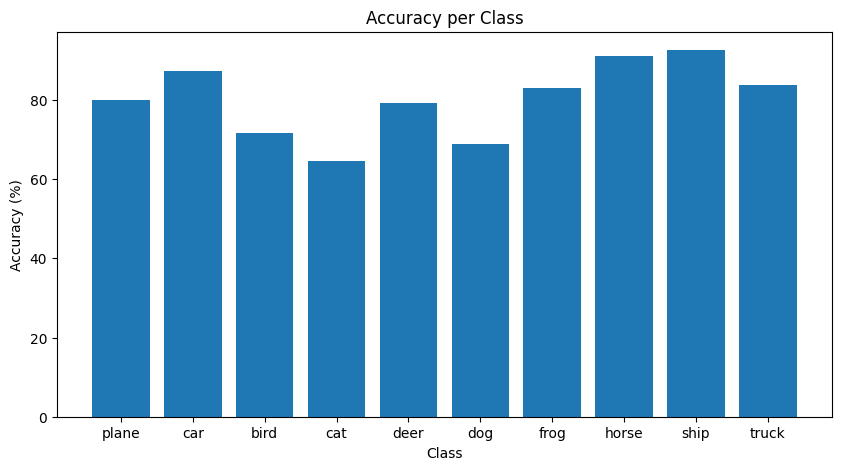

plane: 79.90%
car: 87.40%
bird: 71.70%
cat: 64.60%
deer: 79.20%
dog: 68.90%
frog: 82.90%
horse: 91.00%
ship: 92.60%
truck: 83.80%


In [56]:
loaded_model = load_model('./model/cifar10_model.pth')

# Shearing
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 31.62%


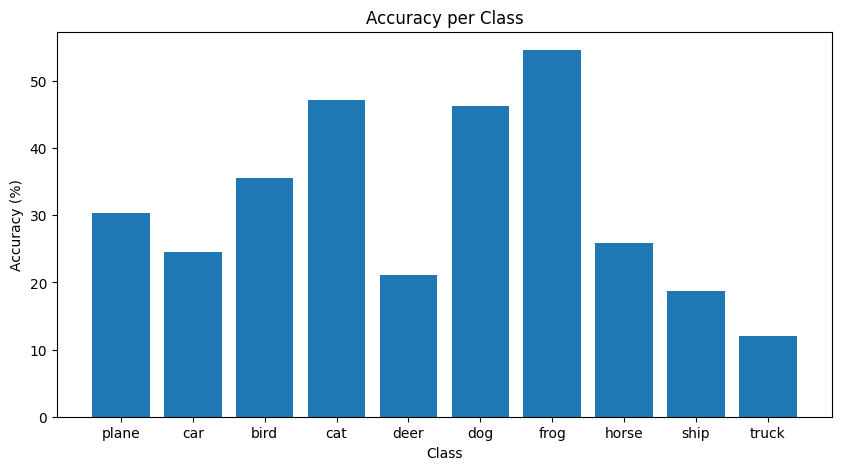

plane: 30.40%
car: 24.60%
bird: 35.60%
cat: 47.10%
deer: 21.10%
dog: 46.20%
frog: 54.60%
horse: 25.90%
ship: 18.70%
truck: 12.00%


In [72]:
loaded_model = load_model('./model/cifar10_model.pth')

# Rotation
import random
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomRotation(degrees=360),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

In [71]:
# loaded_model = load_model('./model/cifar10_model.pth')

# # Rotation
# import random

# def random_rotation(img):
#     angles = [90, 180, 270]
#     angle = random.choice(angles)
#     return transforms.functional.rotate(img, angle)

# test_transforms = transforms.Compose([
#     transforms.Resize(224),
#     transforms.Lambda(random_rotation),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# _, test_loader = load_data(None, test_transforms)
# evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 65.36%


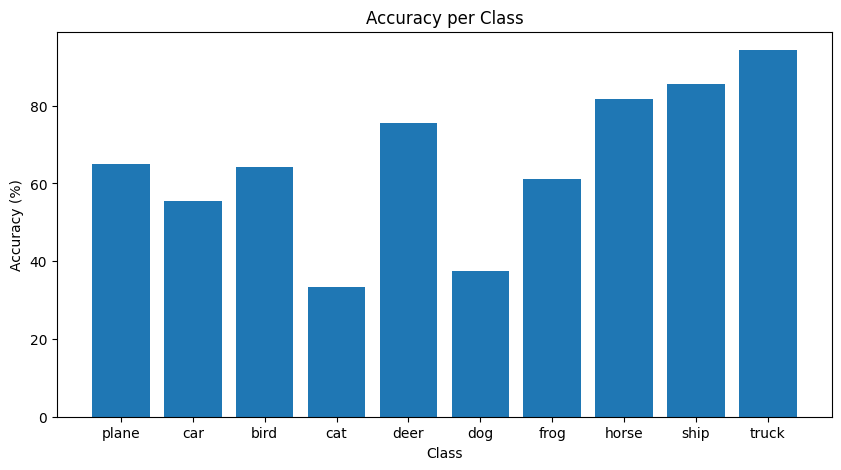

plane: 64.90%
car: 55.60%
bird: 64.30%
cat: 33.30%
deer: 75.50%
dog: 37.40%
frog: 61.10%
horse: 81.70%
ship: 85.50%
truck: 94.30%


In [58]:
class CenterErasing(object):
    def __init__(self, length):
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        y1 = (h - self.length) // 2
        y2 = (h + self.length) // 2
        x1 = (w - self.length) // 2
        x2 = (w + self.length) // 2

        img[:, y1:y2, x1:x2] = 0
        return img

loaded_model = load_model('./model/cifar10_model.pth')

# Cutout
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    CenterErasing(length=56),            
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 81.60%


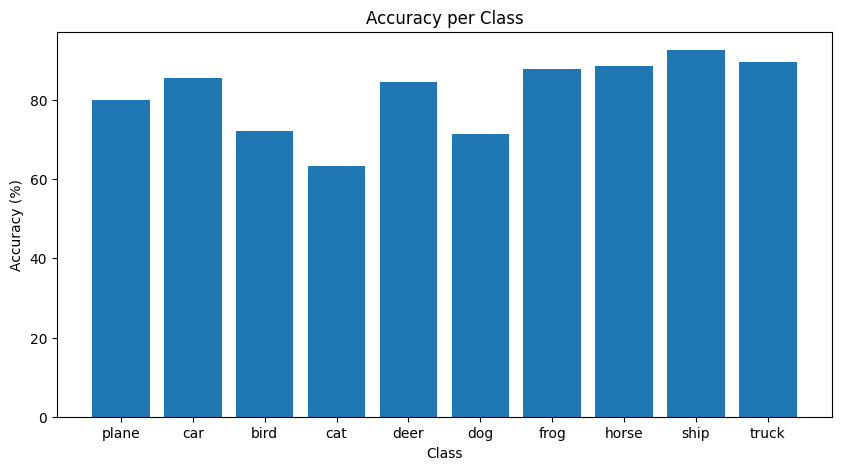

plane: 80.10%
car: 85.60%
bird: 72.20%
cat: 63.30%
deer: 84.60%
dog: 71.50%
frog: 87.90%
horse: 88.60%
ship: 92.60%
truck: 89.60%


In [59]:
loaded_model = load_model('./model/cifar10_model.pth')

# Noise_injection
test_transforms = transforms.Compose([
    transforms.Resize(224),            
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda img: img + 0.1 * torch.randn_like(img)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 80.79%


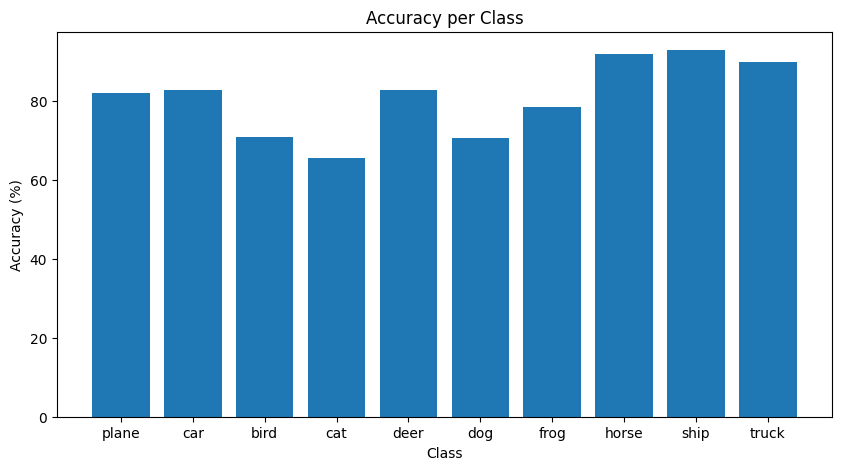

plane: 82.10%
car: 82.90%
bird: 70.80%
cat: 65.60%
deer: 82.70%
dog: 70.50%
frog: 78.40%
horse: 92.00%
ship: 92.90%
truck: 90.00%


In [60]:
loaded_model = load_model('./model/cifar10_model.pth')

# Kernel_filtering
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(9, 11)),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)

/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/hdd1/iknow/anaconda3/envs/simclr/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_492426/2033247822.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/bl

Files already downloaded and verified
Files already downloaded and verified
테스트 정확도: 74.50%


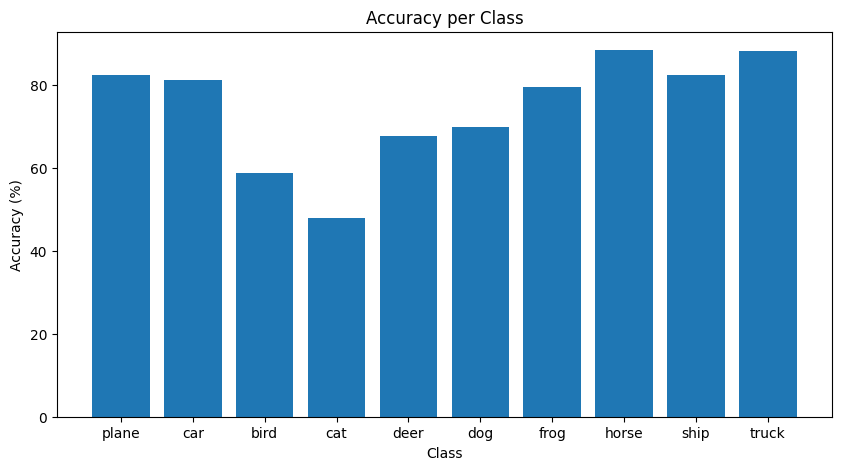

plane: 82.30%
car: 81.00%
bird: 58.70%
cat: 47.80%
deer: 67.50%
dog: 69.70%
frog: 79.40%
horse: 88.30%
ship: 82.20%
truck: 88.10%


In [61]:
loaded_model = load_model('./model/cifar10_model.pth')

# Random_erasing
test_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random'),
])

_, test_loader = load_data(None, test_transforms)
evaluate_model(loaded_model, test_loader)